# 1. Importy i pobranie danych

In [181]:
# Numpy
import numpy as np

# Pandas
import pandas as pd

# Reprezentacja graficzna
import seaborn as sns

# Uczenie
from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

In [182]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_ids = test["PassengerId"]

In [183]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [184]:
# ile i gdzie wartości nullowe
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [185]:
# informacje
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


| Variable|Definition|Key|
|------|------|------|
|survival| Survival|0 = No, 1 = Yes|
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex||
|Age|Age in years||
|sibsp|# of siblings / spouses aboard the Titanic||
|parch	    |# of parents / children aboard the Titanic	||
|ticket	|Ticket number||
|fare|Passenger fare||
|cabin|Cabin number||	
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

Przejdziemy teraz do analizowania i przetwarzania poszczególnych parametrów

# 2. Przygotowanie danych

## 2.1 Nowa kolumna: Family Survived
 Niektóre analizy danych dla lepszego wyniku proponują dodanie kolumny w której znajdują się dane czy ktoś z rodziny jest wśród ludzi ocalonych. 

In [186]:
train['Last_Name'] = train['Name'].apply(lambda x: str.split(x, ",")[0])
test['Last_Name'] = test['Name'].apply(lambda x: str.split(x, ",")[0])
test['Fare'].fillna(test['Fare'].mean(), inplace=True)

train['Family_Survival'] = 0.5
#test['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in train[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                train.loc[train['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                train.loc[train['PassengerId'] == passID, 'Family_Survival'] = 0



for _, grp in train.groupby('Ticket'):
    if (len(grp) != 1):
        for ind, row in grp.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp.drop(ind)['Survived'].max()
                smin = grp.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    train.loc[train['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    train.loc[train['PassengerId'] == passID, 'Family_Survival'] = 0


In [187]:
def family_survive(last_name, fare, ticket):
  df = train[(train['Last_Name'] == last_name) & (train['Fare'] == fare)]
  if len(df) > 0:
    return df.iloc[0]["Family_Survival"]

  df = train[(train['Ticket'] == ticket)]

  if len(df) > 0:
    return df.iloc[0]["Family_Survival"]

  return 0.5


test['Last_Name'] = test['Name'].apply(lambda x: str.split(x, ",")[0])
test['Family_Survival'] = test.apply(lambda x: family_survive(x['Last_Name'], x['Fare'], x['Ticket']), axis=1)


train.drop(labels = ["Last_Name"], axis = 1, inplace = True) # już tych kolumn nie potrzebujemy
test.drop(labels = ["Last_Name"], axis = 1, inplace = True)

In [188]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Survival
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.5
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.5
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.5


In [189]:
test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Survival
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.5
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.5
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.5
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.5
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.5
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0.5
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,0.5
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,1.0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,0.5
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0.0


## 2.2. Name

In [190]:
train["Name"]

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

Możemy dostrzec wszelkiego rodzaju zwroty grzecznościowie i tytuły mogące nam sporo powiedzieć o danej osobie i jej szansie na przetrwanie. Spróbujmy je wyciągnąć

In [191]:
import re as re

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

In [192]:
train['Title'] = train['Name'].apply(get_title)
test['Title'] = test['Name'].apply(get_title)

In [193]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Survival,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.5,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.5,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.5,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.5,Mr
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0.5,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0.5,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0.0,Master
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,1.0,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,0.0,Mrs


Sprawdźmy liczebnośc poszczególnych tytułow

In [194]:
print(pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


Sądząc po ilości osób z danym tutułem, logiczne wydaje mi się zostawienie tylko Dr, Master, Miss, Mr, Mrs, Rev 
a reszte wrzócić do wspólnego koszyka others. Przy okazji przypiszemy Mlle, Mme oraz Ms do kategorii Ms 

In [195]:
def replace_titles(data):
  data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Major', 'Sir', 'Jonkheer', 'Dona', 'Rev'], 'Other')
  data['Title'] = data['Title'].replace('Mlle', 'Mrs')
  data['Title'] = data['Title'].replace('Ms', 'Mrs')
  data['Title'] = data['Title'].replace('Mme', 'Mrs')

replace_titles(train)
replace_titles(test)

In [196]:
print(pd.crosstab(train['Title'], train['Sex']))

Sex     female  male
Title               
Dr           1     6
Master       0    40
Miss       182     0
Mr           0   517
Mrs        129     0
Other        2    14


Sprawdźmy teraz zależnośc pomiędzy tytułem a szansą na przetrwanie

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


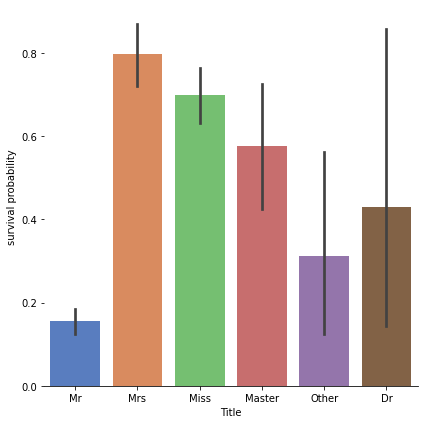

In [197]:
g = sns.factorplot(x="Title",y="Survived",data=train, kind="bar", size = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Można zauważyć że mężczyźni z samym tytułem master mieli raczej niewielkie szanse na przetrwanie

In [198]:
train = pd.get_dummies(train, columns = ["Title"])
test = pd.get_dummies(test, columns = ["Title"])

In [199]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Survival,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.5,0,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.5,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.5,0,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.0,0,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.5,0,0,0,1,0,0


Aby nie powielać informacji usuńmy kolumne Name

In [200]:
train.drop(labels = ["Name"], axis = 1, inplace = True)
test.drop(labels = ["Name"], axis = 1, inplace = True)
train.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Survival,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.5,0,0,0,1,0,0
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0.5,0,0,0,0,1,0
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.5,0,0,1,0,0,0
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,0.0,0,0,0,0,1,0
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,0.5,0,0,0,1,0,0


## 2.2. Age
Sprawdźmy zależnośc pomiędzy Survived a Age

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


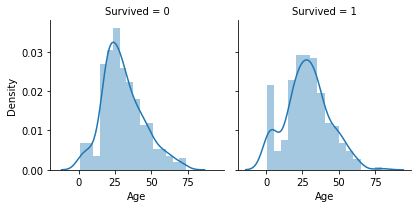

In [201]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

Jak widać rozkłady są bliskie normalnemu, z tą różnicą, że większą szanse na przeżycie mają małe dzieci. Zaś osoby po 65 rż są one minimalne

In [202]:
train["Age"].isnull().sum()

177

Spróbujmy teraz zastąpić czymś te dane, jednakże nie chciałbym ich zastępować medianą, średnią itd. Sprawdźmy czy możemy w jakiś sposób spróbwać oszacować wiek na podstawie innych parametrów. Spodobał mi się pomysł zgdaywania wieku na podstawie innych osób o podobnym Sibsp, Parch oraz Pclass

Źródło: https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling

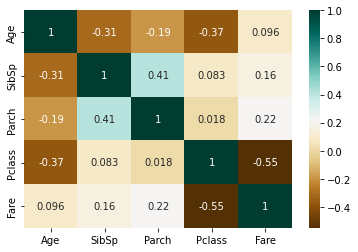

In [203]:
g = sns.heatmap(train[["Age","Sex","SibSp","Parch","Pclass", "Fare"]].corr(),cmap="BrBG",annot=True)

In [204]:

indexes_train = list(train["Age"][train["Age"].isnull()].index)
indexes_test = list(test["Age"][test["Age"].isnull()].index)

def fill_age(data, indexes):
  for i in indexes :
      age_med = train["Age"].median()
      age_pred = train["Age"][((train['SibSp'] == data.iloc[i]["SibSp"]) & (train['Parch'] == data.iloc[i]["Parch"]) & (train['Pclass'] == data.iloc[i]["Pclass"]))].median()
      if not np.isnan(age_pred) :
          data['Age'].iloc[i] = age_pred
      else :
          data['Age'].iloc[i] = age_med

fill_age(train, indexes_train)
fill_age(test, indexes_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [205]:
train["Age"].isnull().sum()

0

In [206]:
train.head(6)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Survival,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.5,0,0,0,1,0,0
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0.5,0,0,0,0,1,0
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.5,0,0,1,0,0,0
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,0.0,0,0,0,0,1,0
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,0.5,0,0,0,1,0,0
5,6,0,3,male,26.0,0,0,330877,8.4583,NaN,Q,0.5,0,0,0,1,0,0


## 2.3. Sex
Sprawdźmy najpierw jak wypada szansa na przeżycie względem płci

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


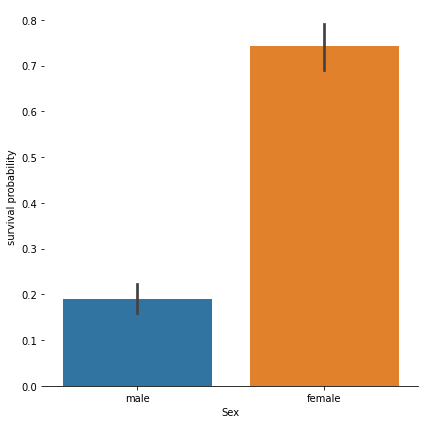

In [207]:
g = sns.factorplot(x="Sex",y="Survived",data=train, kind="bar", size = 6)
g.despine(left=True)
g = g.set_ylabels("survival probability")

Potwierdza się to, czego spodziewaliśmy się przy tytułach, a mianowicie kobiety miały większe szanse przeżycia. Zamieńmy dane kategoralne na numeryczne

In [208]:
def replace_sex(data):
  data['Sex'] = data['Sex'].replace('male', 0)
  data['Sex'] = data['Sex'].replace('female', 1)

replace_sex(train)
replace_sex(test)

In [209]:
train.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Survival,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,1,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,S,0.5,0,0,0,1,0,0
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,C85,C,0.5,0,0,0,0,1,0
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.5,0,0,1,0,0,0
3,4,1,1,1,35.0,1,0,113803,53.1000,C123,S,0.0,0,0,0,0,1,0
4,5,0,3,0,35.0,0,0,373450,8.0500,NaN,S,0.5,0,0,0,1,0,0


## 2.4.Pclass
Sprawdźmy czy istnieje jakaś zależnośc pomiędzy klasą biletu a szansą na przetrwanie

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


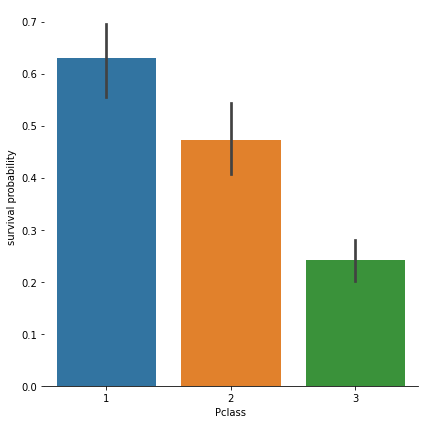

In [210]:
g = sns.factorplot(x="Pclass",y="Survived",data=train, kind="bar", size = 6)
g.despine(left=True)
g = g.set_ylabels("survival probability")

Jak widać osoby bogatsze z lepszymi biletami częściej przeżywały

## 2.5. Ticket

In [211]:
train["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

Spróbujmy oddzielić prefixy biletów. W tym celu napiszmy odpowiedni kod

In [212]:
def get_prefixes(data):
  prefixes = []
  for i in list(data.Ticket):
      if not i.isdigit() :
          prefixes.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
      else:
          prefixes.append("none")
  return prefixes


In [213]:
prefixes = get_prefixes(train)
print(prefixes)

['A5', 'PC', 'STONO2', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'PP', 'none', 'A5', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'PC', 'PC', 'none', 'CA', 'PC', 'none', 'none', 'A5', 'none', 'none', 'none', 'none', 'none', 'SCParis', 'none', 'SCA4', 'none', 'none', 'none', 'none', 'none', 'A4', 'PC', 'none', 'none', 'none', 'CA', 'none', 'CA', 'CA', 'none', 'none', 'none', 'none', 'PC', 'none', 'CA', 'SP', 'none', 'none', 'CA', 'CA', 'SOC', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'SOC', 'none', 'WC', 'SOTONOQ', 'none', 'none', 'none', 'none', 'WEP', 'CA', 'none', 'none', 'PC', 'PC', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'STONO', 'none', 'none', 'PC', 'none', 'SOC', 'A4', 'none', 'none', 'none', 'none', 'none', 'C', 'none', 'none', 'none',

In [214]:
train["Ticket"] = prefixes
train["Ticket"].head()

0        A5
1        PC
2    STONO2
3      none
4      none
Name: Ticket, dtype: object

In [215]:
train['Ticket'].value_counts()

none       661
PC          60
CA          41
A5          21
SOTONOQ     15
STONO       12
WC          10
SCPARIS      7
A4           7
STONO2       6
SOC          6
FCC          5
C            5
SCParis      4
LINE         4
WEP          3
SCAH         3
SOPP         3
PP           3
SOTONO2      2
SWPP         2
PPP          2
FC           1
AS           1
SCOW         1
SC           1
SP           1
Fa           1
SOP          1
SCA4         1
CASOTON      1
Name: Ticket, dtype: int64

Sprawdźmy szanse na przetrwanie w zależności od rodzaju biletu

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


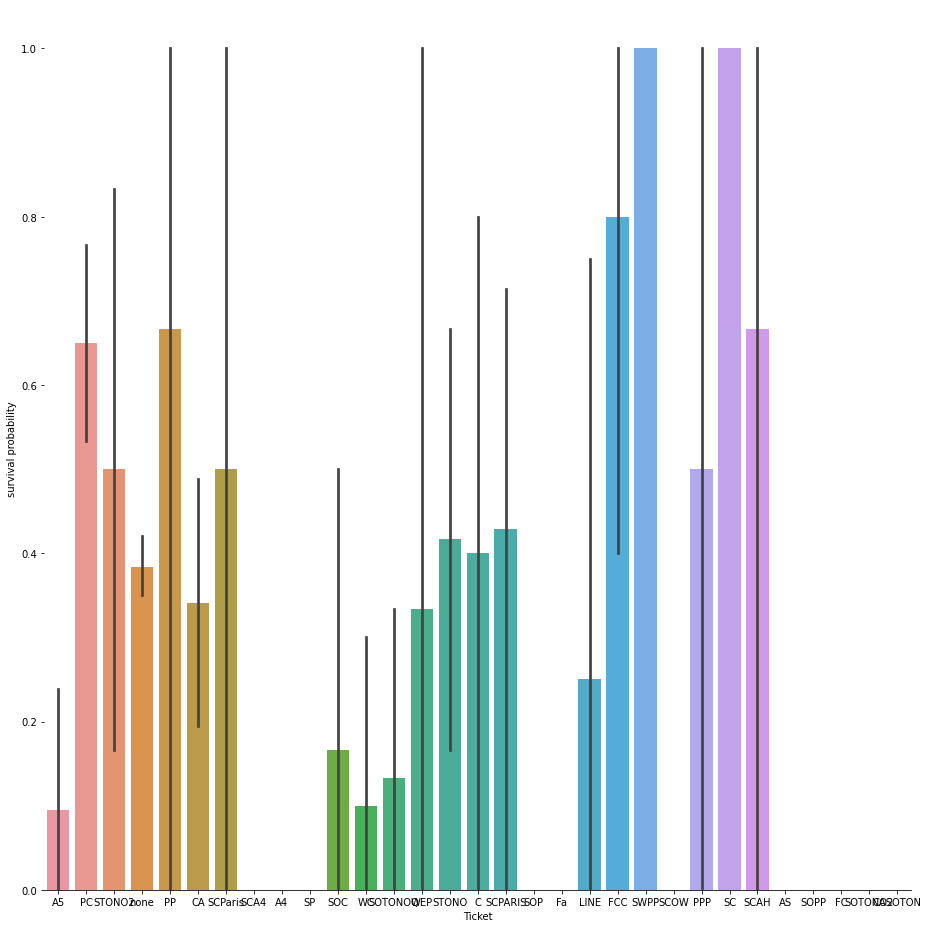

In [216]:
g = sns.factorplot(x="Ticket",y="Survived",data=train, kind="bar", size = 13)
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [217]:
def replace_ticket(data):
  data['Ticket'] = data['Ticket'].replace(['CASOTON', 'SCA4','Fa', 'SP','SC ', 'SCOW', 'AS', 'FC', 'PPP', 'SWPP', 'SOTONO2'], 'Other')

replace_ticket(train)
replace_ticket(test)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


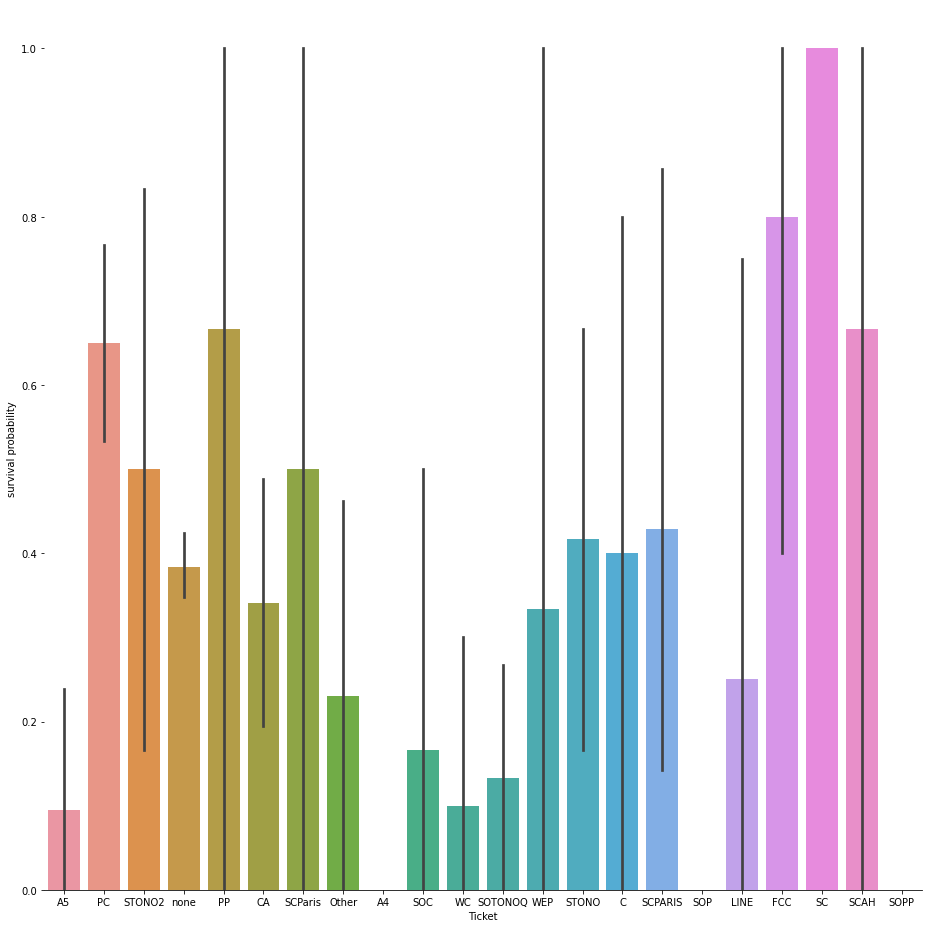

In [218]:
g = sns.factorplot(x="Ticket",y="Survived",data=train, kind="bar", size = 13)
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [219]:
train = pd.get_dummies(train, columns = ["Ticket"])
test = pd.get_dummies(test, columns = ["Ticket"])
train.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,...,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONOQ,Ticket_STONO,Ticket_STONO2,Ticket_WC,Ticket_WEP,Ticket_none
0,1,0,3,0,22.0,1,0,7.2500,NaN,S,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,1,38.0,1,0,71.2833,C85,C,...,0,0,0,0,0,0,0,0,0,0
2,3,1,3,1,26.0,0,0,7.9250,NaN,S,...,0,0,0,0,0,0,1,0,0,0
3,4,1,1,1,35.0,1,0,53.1000,C123,S,...,0,0,0,0,0,0,0,0,0,1
4,5,0,3,0,35.0,0,0,8.0500,NaN,S,...,0,0,0,0,0,0,0,0,0,1


## 2.6.Cabin

In [220]:
train["Cabin"].head(10)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: Cabin, dtype: object

In [221]:
train["Cabin"].isnull().sum()

687

Widzimy, że w Cabin brakuje sporej ilości wartości. Musimy jakoś zepłnić te dane.Ponadto zamieńmy dokadny numer kabiny na litere pokładu na którym się znajdował

In [222]:
train["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'none' for i in train['Cabin'] ])
test["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'none' for i in test['Cabin'] ])

In [223]:
train["Cabin"].isnull().sum()

0

In [224]:
train["Cabin"].head(5)

0    none
1       C
2    none
3       C
4    none
Name: Cabin, dtype: object

In [225]:
train['Cabin'].value_counts()

none    687
C        59
B        47
D        33
E        32
A        15
F        13
G         4
T         1
Name: Cabin, dtype: int64

Sprawdźmy teraz szansę przeżycia w zależności od posiadanej kabiny

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


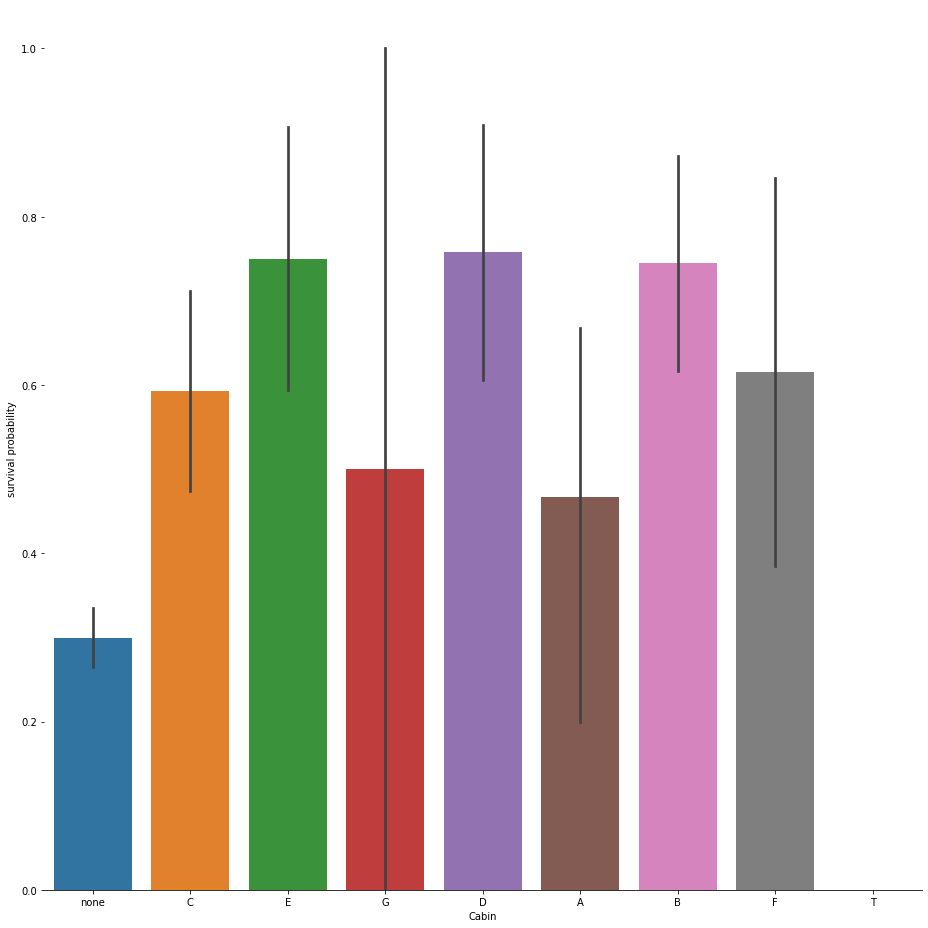

In [226]:
g = sns.factorplot(x="Cabin",y="Survived",data=train, kind="bar", size = 13)
g.despine(left=True)
g = g.set_ylabels("survival probability")

Jak widać największe szanse na przeżycie miały osoby z kabin B, D, E

In [227]:
train = pd.get_dummies(train, columns = ["Cabin"])
test = pd.get_dummies(test, columns = ["Cabin"])
train.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family_Survival,...,Ticket_none,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_none
0,1,0,3,0,22.0,1,0,7.2500,S,0.5,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,1,38.0,1,0,71.2833,C,0.5,...,0,0,0,1,0,0,0,0,0,0
2,3,1,3,1,26.0,0,0,7.9250,S,0.5,...,0,0,0,0,0,0,0,0,0,1
3,4,1,1,1,35.0,1,0,53.1000,S,0.0,...,1,0,0,1,0,0,0,0,0,0
4,5,0,3,0,35.0,0,0,8.0500,S,0.5,...,1,0,0,0,0,0,0,0,0,1


## 2.7. sibsp oraz parch
Postanowiłem połączyć te kolumny w jedną o nazwie "Family size".

In [228]:
train["Family size"] = train["SibSp"] + train["Parch"] + 1
test["Family size"] = test["SibSp"] + test["Parch"] + 1

Sprawdźmy czy wielkość rodziny wpływa jakoś na szanse przeżycia

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


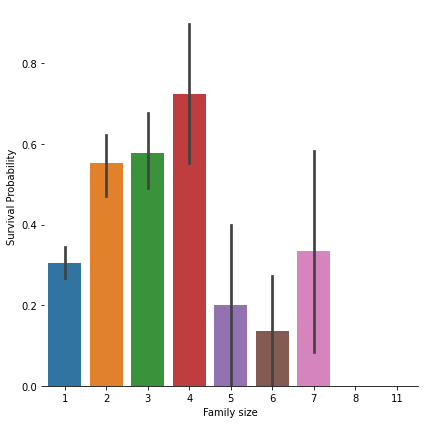

In [229]:
g = sns.factorplot(x="Family size",y="Survived",data=train, kind="bar", size = 6)
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

Jak widać małe rodziny miały większe szanse przetrwania. Podzielmy te grupy na podgrupy: single, mała rdzoina, średnia rodzina, duża rodzina. Po czym usuńmy kolumny SibSp oraz Parch

In [230]:
def family_size(data):
  data['Single'] = data['Family size'].map(lambda s: 1 if s == 1 else 0)
  data['SmallFamily'] = data['Family size'].map(lambda s: 1 if  s == 2  else 0)
  data['MediumFamily'] = data['Family size'].map(lambda s: 1 if 3 <= s <= 4 else 0)
  data['LargeFamily'] = data['Family size'].map(lambda s: 1 if s >= 5 else 0)

  data.drop(labels = ["SibSp"], axis = 1, inplace = True)
  data.drop(labels = ["Parch"], axis = 1, inplace = True)

family_size(train)
family_size(test)


In [231]:
train.head(5)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Family_Survival,Title_Dr,Title_Master,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_none,Family size,Single,SmallFamily,MediumFamily,LargeFamily
0,1,0,3,0,22.0,7.2500,S,0.5,0,0,...,0,0,0,0,1,2,0,1,0,0
1,2,1,1,1,38.0,71.2833,C,0.5,0,0,...,0,0,0,0,0,2,0,1,0,0
2,3,1,3,1,26.0,7.9250,S,0.5,0,0,...,0,0,0,0,1,1,1,0,0,0
3,4,1,1,1,35.0,53.1000,S,0.0,0,0,...,0,0,0,0,0,2,0,1,0,0
4,5,0,3,0,35.0,8.0500,S,0.5,0,0,...,0,0,0,0,1,1,1,0,0,0


Tutaj chciałbym zwrócić uwagę na jedną kwestię. W kilku analizach danych spotkałem się z stwierdzeniem, że nie należy używać tych kolumn. Związane jest to z fatem że występują tam błędy, takie ja podróżująca razem z córką matka z córką (nazwisko Watt jakby ktoś chciał sprawdzić), które mające obie w tych kolumnach po zero

Źródło: https://www.kaggle.com/code/cdeotte/titantic-mega-model-0-84210/notebook

Ja natomiast postaram się przetestować obie wersje (jeśli powyższy kod został zastąpiony komentarzem to znaczy że lepiej poradziła sobie wersja bez tych kolumn)

## 2.8. Fare
Sprawdźmy teraz opłaty za przepływ

In [232]:
train["Fare"].isnull().sum()


0

In [233]:
test["Fare"].isnull().sum()

0

Przyjżyjmy się teraz uważniej zakresowi

In [234]:
train["Fare"].describe(include=(np.number))

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

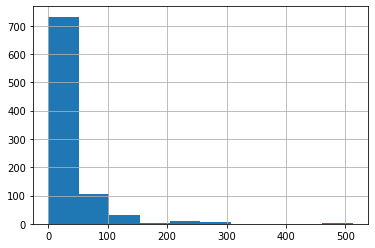

In [235]:
train['Fare'].hist();

Jak widać mamy bardzo dużo małych wartości a niewiele dużych (wartości odstające). Spróbujmy więc przeskalować tą kolumne

In [236]:
train['LogFare'] = np.log(train['Fare']+1)
test['LogFare'] = np.log(test['Fare']+1)

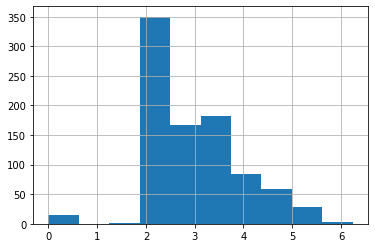

In [237]:
train['LogFare'].hist();

Teraz wygląda to lepiej. Jeszcze tylko usuńmy starą kolumne

In [238]:
train.drop(labels = ["Fare"], axis = 1, inplace = True)
test.drop(labels = ["Fare"], axis = 1, inplace = True)

In [239]:
train.head(5)

,PassengerId,Survived,Pclass,Sex,Age,Embarked,Family_Survival,Title_Dr,Title_Master,Title_Miss,...,Cabin_F,Cabin_G,Cabin_T,Cabin_none,Family size,Single,SmallFamily,MediumFamily,LargeFamily,LogFare
0,1,0,3,0,22.0,S,0.5,0,0,0,...,0,0,0,1,2,0,1,0,0,2.110213
1,2,1,1,1,38.0,C,0.5,0,0,0,...,0,0,0,0,2,0,1,0,0,4.280593
2,3,1,3,1,26.0,S,0.5,0,0,1,...,0,0,0,1,1,1,0,0,0,2.188856
3,4,1,1,1,35.0,S,0.0,0,0,0,...,0,0,0,0,2,0,1,0,0,3.990834
4,5,0,3,0,35.0,S,0.5,0,0,0,...,0,0,0,1,1,1,0,0,0,2.202765


## 2.9. Embarked
Na początku pozbądźmy się nullów. W tym celu sprawdźmy która wartość jest najpopularniejsza i wypełnijmy ją puste rubryki. Usunięcie tej kolumny daje pozytywny rezultat

In [240]:
train["Embarked"].isnull().sum()

2

In [241]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [242]:
# train["Embarked"] = train["Embarked"].fillna("S")
# test["Embarked"] = test["Embarked"].fillna("S")

In [243]:
#train["Embarked"].isnull().sum()

In [244]:
#train['Embarked'].value_counts()

In [245]:
# g = sns.factorplot(x="Embarked",y="Survived",data=train, kind="bar", size = 6)
# g.despine(left=True)
# g = g.set_ylabels("Survival Probability")

Z jakiegoś powodu osoby wsiadające w C mają największe szanse przeżycia

In [246]:
# train = pd.get_dummies(train, columns = ["Embarked"])
# test = pd.get_dummies(test, columns = ["Embarked"])

In [247]:
# data.head(5)
train.drop(labels = ["Embarked"], axis = 1, inplace = True)
test.drop(labels = ["Embarked"], axis = 1, inplace = True)

## 2.10 PassengerId
Po prostu wyrzucamy, to nie ma żadnego wpływu na predykcje

In [248]:
train.drop(labels = ["PassengerId"], axis = 1, inplace = True)
test.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [249]:
missing_cols = set( train.columns ) - set( test.columns )
for c in missing_cols:
    test[c] = 0

test = test[train.columns]
test.drop(labels = ["Survived"], axis = 1, inplace = True)
print(train.columns)
print(test.columns)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Family_Survival', 'Title_Dr',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other',
       'Ticket_A4', 'Ticket_A5', 'Ticket_C', 'Ticket_CA', 'Ticket_FCC',
       'Ticket_LINE', 'Ticket_Other', 'Ticket_PC', 'Ticket_PP', 'Ticket_SC',
       'Ticket_SCAH', 'Ticket_SCPARIS', 'Ticket_SCParis', 'Ticket_SOC',
       'Ticket_SOP', 'Ticket_SOPP', 'Ticket_SOTONOQ', 'Ticket_STONO',
       'Ticket_STONO2', 'Ticket_WC', 'Ticket_WEP', 'Ticket_none', 'Cabin_A',
       'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G',
       'Cabin_T', 'Cabin_none', 'Family size', 'Single', 'SmallFamily',
       'MediumFamily', 'LargeFamily', 'LogFare'],
      dtype='object')
Index(['Pclass', 'Sex', 'Age', 'Family_Survival', 'Title_Dr', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other', 'Ticket_A4',
       'Ticket_A5', 'Ticket_C', 'Ticket_CA', 'Ticket_FCC', 'Ticket_LINE',
       'Ticket_Other', 'Ticket_PC', 'T

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# 3. Trenowanie modelu

In [250]:
train.head(5)

,Survived,Pclass,Sex,Age,Family_Survival,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Cabin_F,Cabin_G,Cabin_T,Cabin_none,Family size,Single,SmallFamily,MediumFamily,LargeFamily,LogFare
0,0,3,0,22.0,0.5,0,0,0,1,0,...,0,0,0,1,2,0,1,0,0,2.110213
1,1,1,1,38.0,0.5,0,0,0,0,1,...,0,0,0,0,2,0,1,0,0,4.280593
2,1,3,1,26.0,0.5,0,0,1,0,0,...,0,0,0,1,1,1,0,0,0,2.188856
3,1,1,1,35.0,0.0,0,0,0,0,1,...,0,0,0,0,2,0,1,0,0,3.990834
4,0,3,0,35.0,0.5,0,0,0,1,0,...,0,0,0,1,1,1,0,0,0,2.202765


In [251]:
test.head(5)

,Pclass,Sex,Age,Family_Survival,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,...,Cabin_F,Cabin_G,Cabin_T,Cabin_none,Family size,Single,SmallFamily,MediumFamily,LargeFamily,LogFare
0,3,0,34.5,0.5,0,0,0,1,0,0,...,0,0,0,1,1,1,0,0,0,2.178064
1,3,1,47.0,0.5,0,0,0,0,1,0,...,0,0,0,1,2,0,1,0,0,2.079442
2,2,0,62.0,0.5,0,0,0,1,0,0,...,0,0,0,1,1,1,0,0,0,2.369075
3,3,0,27.0,0.5,0,0,0,1,0,0,...,0,0,0,1,1,1,0,0,0,2.268252
4,3,1,22.0,0.5,0,0,0,0,1,0,...,0,0,0,1,3,0,0,1,0,2.586824


In [252]:
#test.drop(labels = ["Survived"], axis = 1, inplace = True)

In [253]:
test.head(5)

,Pclass,Sex,Age,Family_Survival,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,...,Cabin_F,Cabin_G,Cabin_T,Cabin_none,Family size,Single,SmallFamily,MediumFamily,LargeFamily,LogFare
0,3,0,34.5,0.5,0,0,0,1,0,0,...,0,0,0,1,1,1,0,0,0,2.178064
1,3,1,47.0,0.5,0,0,0,0,1,0,...,0,0,0,1,2,0,1,0,0,2.079442
2,2,0,62.0,0.5,0,0,0,1,0,0,...,0,0,0,1,1,1,0,0,0,2.369075
3,3,0,27.0,0.5,0,0,0,1,0,0,...,0,0,0,1,1,1,0,0,0,2.268252
4,3,1,22.0,0.5,0,0,0,0,1,0,...,0,0,0,1,3,0,0,1,0,2.586824


In [254]:
y = train["Survived"]
X = train.drop("Survived", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [255]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
test = scaler.fit_transform(test)

In [256]:
kfold = StratifiedKFold(n_splits=10)

Zdecydowałem się do użycia w swoim ensamble GradientBoosting, LogisticRegression, MultipleLayerPerceptron oraz RandomForest 

In [257]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_


gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8468896713615024

In [258]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8497261345852894

In [259]:
# Logistic Regression tunning

LR = LogisticRegression()


LR_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}


gsLR = GridSearchCV(LR,param_grid = LR_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsLR.fit(X_train,y_train)

LR_best = gsLR.best_estimator_

gsLR.best_score_

Fitting 10 folds for each of 35 candidates, totalling 350 fits


0.844092331768388

In [260]:
# MultipleLayerPerceptron tunning

# MLP = MLPClassifier()

# MLP_param_grid = {
#     'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],
# }
# gsMLP = GridSearchCV(MLP, param_grid = MLP_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# gsMLP.fit(X_train,y_train)

# MLP_best = gsMLP.best_estimator_

# # Best score
# gsMLP.best_score_

In [261]:
#XGBoost

from scipy.stats.distributions import uniform, randint
param_distribution = {
    'max_depth': randint(3, 20),
    'learning_rate': uniform(0.001, 0.1-0.001),
    'n_estimators': randint(50, 600),
    'gamma': uniform(0,2),
    'colsample_bytree': uniform(0.5, 0.5),
    'subsample': uniform(0.5, 0.5),
    'min_child_weight': randint(1, 11)
}

from sklearn.model_selection import RandomizedSearchCV

model = XGBClassifier()
model.fit(X_train, y_train) 
gsXGB = RandomizedSearchCV(estimator=model
                                 , param_distributions=param_distribution
                                 , n_iter=64
                                 , scoring='roc_auc' )

gsXGB.fit(X_train, y_train)
XGB_best = gsXGB.best_estimator_

# Best score
gsXGB.best_score_

0.8921572894516503

In [262]:
gsXGB.best_params_

{'colsample_bytree': 0.790286842291104,
 'gamma': 1.5566777764715727,
 'learning_rate': 0.05444519388573081,
 'max_depth': 11,
 'min_child_weight': 6,
 'n_estimators': 222,
 'subsample': 0.8132283206417126}

In [263]:
votingC = VotingClassifier(estimators=[ ('LR', LR_best),('RFC', RFC_best),
('GBC',GBC_best), ('XGB', XGB_best)], voting='hard')

votingC = votingC.fit(X_train, y_train)

In [264]:
predictions = votingC.predict(X_test)
#predictions = XGB_best.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.8547486033519553

In [266]:
submission_preds = votingC.predict(test)
df = pd.DataFrame({"PassengerId":test_ids.values, 
                  "Survived":submission_preds})

df["Survived"] = df["Survived"].astype('int64')
df.to_csv("submission.csv", index=False)